# "Dropout and Batch Normalization"
> "Add functionality using layers not containing any neurons themselves but benefiting a model in various ways."

- toc: true
- branch: master
- badges: true
- comments: true
- author: Rishiraj Acharya
- categories: [deep learning, regularization, normalization]
- image: images/nb/dropout.gif
- hide: false
- search_exclude: false

# Introduction

There's so much more to Chicken Biryani than just the chicken. Surely chicken plays the most important role, but the rice, the masala (and the potato if you're a Bengali) are important too. Similarly, in deep learning, there're layers apart from the dense layers that plays different important roles. Let's discuss two of them.

In [1]:
# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

# Dropout

Dropout is an important technique for regularization that only emerged recently, thanks to Geoffrey Hinton and works amazingly well. In deep learning we have one layer connecting to another layer and the values that go from one layer to the next are called activations. Dropout takes these activations and randomly set half of them to zero for every example we train our network on. Simply put, it iteratively takes half of the data that's flowing through our network and just drops it. Thus, our network can never rely on any given activation to be present because they might be dropped at any given iteration. So it is forced to learn a redundant representation for everything to make sure that at least some of the information remains. This makes the network robust and prevents overfitting all while making it act like taking an agreement of an ensemble of networks.

## Load Dataset and Preprocess

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

spotify = pd.read_csv('/content/spotify.csv')

X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [18]


## Define and fit the original Model

Minimum Validation Loss: 0.1922


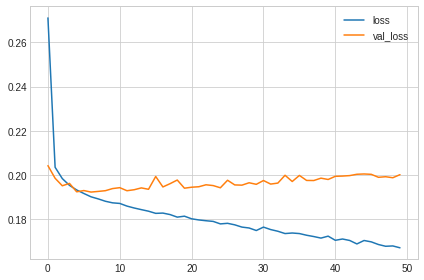

In [3]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

model.compile(
    optimizer='adam',
    loss='mae',
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0,
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

## Define and fit the Model with Dropout

In [4]:
# Adding two 30% dropout layers, one after 128 and one after 64
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)
])

Minimum Validation Loss: 0.1879


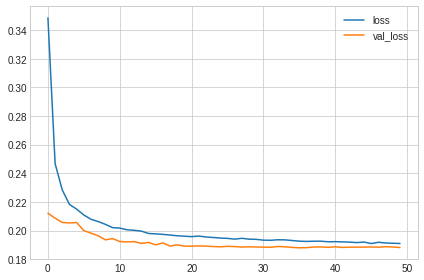

In [5]:
model.compile(
    optimizer='adam',
    loss='mae',
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0,
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

From the learning curves, we can see that the validation loss remains near a constant minimum even though the training loss continues to decrease. So we can see that adding dropout did prevent overfitting this time. Moreover, by making it harder for the network to fit spurious patterns, dropout may have encouraged the network to seek out more of the true patterns, possibly improving the validation loss some as well).

# Batch Normalization

In deep learning it is a common practice to normalize the data on a similar scale before it goes to the network. We can easily achieve this through the scalers available from [sklearn.preprocessing](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing) and has the effect of preventing the network from getting unstable with the weights being shifted in proportion to how large an activation the data produces. In a same way Batch Normalization normalizes the data on a similar scale when it's inside the network, just before or after the activation function of each hidden layer. It zero-centers and normalizes each input, then shifts and scales the result using one new parameter vector for shifting and another for scaling for each layer. This makes the network learn the optimal scale and mean of each of the layer's inputs.

## Load Dataset and Preprocess

In [6]:
import pandas as pd

concrete = pd.read_csv('/content/concrete.csv')
df = concrete.copy()

df_train = df.sample(frac=0.7, random_state=0)
df_valid = df.drop(df_train.index)

X_train = df_train.drop('CompressiveStrength', axis=1)
X_valid = df_valid.drop('CompressiveStrength', axis=1)
y_train = df_train['CompressiveStrength']
y_valid = df_valid['CompressiveStrength']

input_shape = [X_train.shape[1]]

## Define and fit the original Model

Minimum Validation Loss: nan


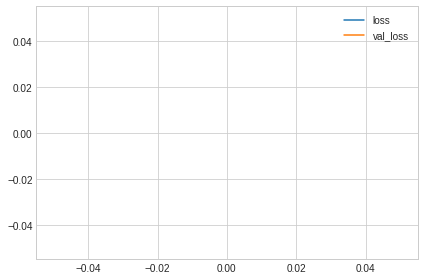

In [7]:
model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.Dense(512, activation='relu'),    
    layers.Dense(512, activation='relu'),
    layers.Dense(1),
])

model.compile(
    optimizer='sgd', # SGD is more sensitive to differences of scale
    loss='mae',
    metrics=['mae'],
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=100,
    verbose=0,
)

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))

## Define and fit the Model with Batch Normalization

In [8]:
# Adding a BatchNormalization layer before each Dense layer
model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1),
])

Minimum Validation Loss: 3.9774


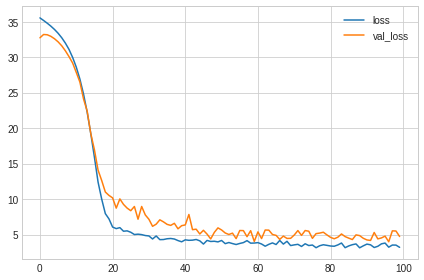

In [9]:
model.compile(
    optimizer='sgd',
    loss='mae',
    metrics=['mae'],
)

EPOCHS = 100
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=EPOCHS,
    verbose=0,
)

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))

We can see that adding batch normalization was a big improvement on the first attempt! By adaptively scaling the data as it passes through the network, batch normalization can let us train models on difficult datasets.